In [2]:
#importamos pandas para leer la data en df
import pandas as pd
#con pandas_gbq es para interactuar con bigquery
import pandas_gbq

# Objetivo: Vamos a crear la conexión con BigQuery y vamos a leer mediante
# consulta SQL desde Python.
# Generamos conexion a bigquery

from google.oauth2 import service_account # para generar conexion
bq_cred = service_account.Credentials.from_service_account_file('cedar-pottery-388916-edca8400ae77.json')      

sql = "SELECT latitude, longitude, avg_rating, category FROM `cedar-pottery-388916.conjunto_testing.beauty_business` LIMIT 151503"
data_area = pd.read_gbq(sql, project_id='cedar-pottery-388916', credentials = bq_cred, dialect='standard')


# Clustering - USA

In [4]:
import warnings
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joblib
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import numpy as np

# Restaurar el filtro de advertencias a su configuración original
warnings.filterwarnings('default')

# Seleccionar las columnas relevantes para el clustering
X = data_area[['latitude', 'longitude', 'avg_rating']]

# Escalar las variables de entrada
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar el algoritmo de clustering K-means
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(X_scaled)

# Obtener el centroide (zona central) de cada cluster
centers = scaler.inverse_transform(kmeans.cluster_centers_)

avg_ratios = []
densities = []
proximities = []
competitors = []

for i, center in enumerate(centers):
    cluster_points = data_area.loc[kmeans.labels_ == i, ['latitude', 'longitude']]
    distances = cluster_points.apply(lambda point: geodesic((center[0], center[1]), (point['latitude'], point['longitude'])).kilometers, axis=1)

    cluster_avg_ratings = data_area['avg_rating'][kmeans.labels_ == i]
    avg_ratio = np.mean(cluster_avg_ratings)
    avg_ratios.append(avg_ratio)

    density = len(cluster_points)
    densities.append(density)

    proximity = distances.mean()
    proximities.append(proximity)

    competitor_count = len(data_area[(kmeans.labels_ == i) & (data_area['avg_rating'] > avg_ratio)])
    competitors.append(competitor_count)


# Crear un DataFrame con los resultados
result = pd.DataFrame({'Cluster': range(50),
                       'Centroid Latitude': centers[:, 0],
                       'Centroid Longitude': centers[:, 1],
                       'Avg Ratio': avg_ratios,
                       'Density': densities,
                       'Competitors': competitors})

# Ordenar los clusters por Avg Ratio de mayor a menor
top_clusters = result.sort_values(by='Avg Ratio', ascending=False)

top_clusters["Avg Ratio"] = top_clusters["Avg Ratio"].apply(round, args=(2,))

geolocator = Nominatim(user_agent="my_geocoder")

def get_state_location(latitude, longitude):
    try:
        location = geolocator.reverse((latitude, longitude), exactly_one=True)
        address = location.raw['address']
        state = address.get('state', '')
        county = address.get('county', '')
    except:
        return "Florida", "Hernando County"


# Agregar columnas de estado y ubicación geográfica al DataFrame 'top_clusters'
top_clusters[['State', 'Location']] = top_clusters.apply(lambda row: pd.Series(get_state_location(row['Centroid Latitude'], row['Centroid Longitude'])), axis=1)

top_clusters = top_clusters.reset_index(drop=True)

top_clusters["Porcentaje de competición"] = round((top_clusters["Competitors"])/top_clusters["Density"]*100,2)
top_clusters["Porcentaje de competición"] = top_clusters["Porcentaje de competición"].apply(float)

top_clusters.rename(columns={"Avg Ratio": "Promedio_Puntaje_Reviews", 
                             "Density": "Cantidad de Negocios",
                             "Competitors": "Negocios Competidores",
                             "State": "Estado",
                             "Location": "Condado"
                             }, inplace=True)

C:\Users\gonza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gonza\AppData\Local\Temp\ipykernel_2824\2612867875.py:76: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  top_clusters[['State', 'Location']] = top_clusters.apply(lambda row: pd.Series(get_state_location(row['Centroid Latitude'], row['Centroid Longitude'])), axis=1)
C:\Users\gonza\AppData\Local\Temp\ipykernel_2824\2612867875.py:76: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  top_clusters[['State', 'Location']] = top_clust

In [5]:
outliers_indices = []

# Calcular el rango intercuartil (IQR) para cada cluster
for i, center in enumerate(centers):
    cluster_points = data_area.loc[kmeans.labels_ == i, ['latitude', 'longitude']]
    distances = cluster_points.apply(lambda point: geodesic((center[0], center[1]), (point['latitude'], point['longitude'])).kilometers, axis=1)

    q1 = np.percentile(distances, 25)
    q3 = np.percentile(distances, 75)
    iqr = q3 - q1

    # Calcular los límites para definir los valores atípicos
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Obtener los índices de los valores atípicos en el cluster
    outliers_indices.extend(cluster_points[~(distances >= lower_bound) | ~(distances <= upper_bound)].index)

# Eliminar los valores atípicos de data_area
data_area = data_area.drop(outliers_indices)

# Mostrar la cantidad total de valores atípicos eliminados
print("Total de valores atípicos eliminados:", len(outliers_indices))




Total de valores atípicos eliminados: 5789


### Al eliminar valores atípicos de los clusters hay que volver a entrenar el modelo para que se estabilicen dichos grupos

In [6]:

# Restaurar el filtro de advertencias a su configuración original
warnings.filterwarnings('default')

# Seleccionar las columnas relevantes para el clustering
X = data_area[['latitude', 'longitude', 'avg_rating']]

# Escalar las variables de entrada
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar el algoritmo de clustering K-means
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(X_scaled)

# Guardar el modelo de clustering
joblib.dump(kmeans, 'kmeans_model.pkl')

# Obtener el centroide (zona central) de cada cluster
centers = scaler.inverse_transform(kmeans.cluster_centers_)

joblib.dump(centers, 'cluster_centers.pkl')

avg_ratios = []
densities = []
proximities = []
competitors = []

for i, center in enumerate(centers):
    cluster_points = data_area.loc[kmeans.labels_ == i, ['latitude', 'longitude']]
    distances = cluster_points.apply(lambda point: geodesic((center[0], center[1]), (point['latitude'], point['longitude'])).kilometers, axis=1)

    cluster_avg_ratings = data_area['avg_rating'][kmeans.labels_ == i]
    avg_ratio = np.mean(cluster_avg_ratings)
    avg_ratios.append(avg_ratio)

    density = len(cluster_points)
    densities.append(density)

    proximity = distances.mean()
    proximities.append(proximity)

    competitor_count = len(data_area[(kmeans.labels_ == i) & (data_area['avg_rating'] > avg_ratio)])
    competitors.append(competitor_count)


# Crear un DataFrame con los resultados
result = pd.DataFrame({'Cluster': range(50),
                       'Centroid Latitude': centers[:, 0],
                       'Centroid Longitude': centers[:, 1],
                       'Avg Ratio': avg_ratios,
                       'Density': densities,
                       'Competitors': competitors})

# Ordenar los clusters por Avg Ratio de mayor a menor
top_clusters = result.sort_values(by='Avg Ratio', ascending=False)

top_clusters["Avg Ratio"] = top_clusters["Avg Ratio"].apply(round, args=(2,))

geolocator = Nominatim(user_agent="my_geocoder")

def get_state_location(latitude, longitude):
    try:
        location = geolocator.reverse((latitude, longitude), exactly_one=True)
        address = location.raw['address']		
        state = address.get('state', '')
        county = address.get('county', '')
        if round(latitude, 6) == 21.243654 and round(longitude, 6) == -157.623001:
            return "Hawaii", "Honolulu County"
        elif round(latitude, 6) == 35.743958 and round(longitude, 6) == -116.650414: 		
            return "California", "San Bernardino County"
        elif round(latitude, 6) == 42.316927 and round(longitude, 6) == -86.768728:
            return "Michigan", "Allegan County" 
        elif round(latitude, 6) == 46.221938 and round(longitude, 6) == -121.162351:
            return "Washington", "Yakima County" 
        return state, county
    except:
        return "Florida", "Hernando County"
# Agregar columnas de estado y ubicación geográfica al DataFrame 'top_clusters'
top_clusters[['State', 'Location']] = top_clusters.apply(lambda row: pd.Series(get_state_location(row['Centroid Latitude'], row['Centroid Longitude'])), axis=1)

top_clusters = top_clusters.reset_index(drop=True)

top_clusters["Porcentaje de competición"] = round((top_clusters["Competitors"])/top_clusters["Density"]*100,2)
top_clusters["Porcentaje de competición"] = top_clusters["Porcentaje de competición"].apply(float)

top_clusters.rename(columns={"Avg Ratio": "Promedio_Puntaje_Reviews", 
                             "Density": "Cantidad de Negocios",
                             "Competitors": "Negocios Competidores",
                             "State": "Estado",
                             "Location": "Condado"
                             }, inplace=True)

C:\Users\gonza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
# Guardar el modelo entregado en un archivo pickle

joblib.dump(kmeans, 'kmeans_model.pkl')

# Obtener el centroide (zona central) de cada cluster
centers = scaler.inverse_transform(kmeans.cluster_centers_)

joblib.dump(centers, 'cluster_centers.pkl')

['cluster_centers.pkl']

In [8]:
top_clusters.to_csv("top_clusters.csv")

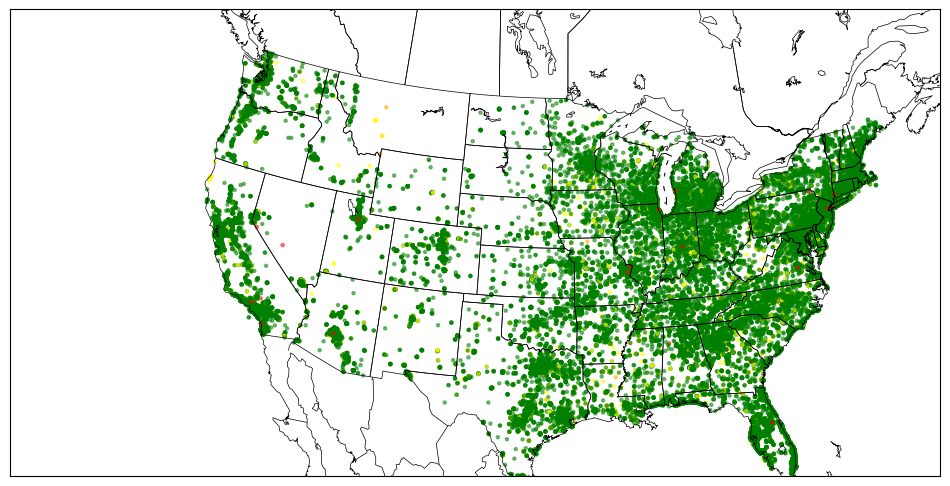

In [15]:
from mpl_toolkits.basemap import Basemap
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

# Crear un mapa centrado en Estados Unidos
m = Basemap(
    llcrnrlon=-130,
    llcrnrlat=20,
    urcrnrlon=-60,
    urcrnrlat=50,
    projection='lcc',
    lat_1=33,
    lat_2=45,
    lon_0=-95,
    resolution='l'
)

# Dibujar las costas y las fronteras de los estados
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.drawstates(linewidth=0.5)

# Convertir las coordenadas a coordenadas del mapa
x, y = m(data_area['longitude'].values, data_area['latitude'].values)

# Definir los colores en función de Avg Ratio
colors = ['red' if ratio < 2 else 'orange' if ratio < 3 else 'yellow' if ratio < 4 else 'green' for ratio in data_area['avg_rating']]

# Dibujar los puntos en el mapa con los colores definidos
m.scatter(x, y, c=colors, s=5, cmap='coolwarm', alpha=0.5)


# Mostrar el mapa
plt.show()
# Mostrar el mapa



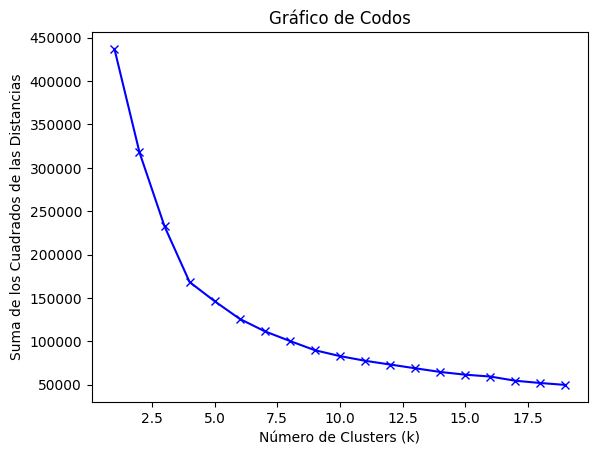

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings

# Configurar el filtro para ignorar las advertencias de nivel predeterminado
warnings.filterwarnings('ignore')

# Código que genera las advertencias

# Cargar el dataset


# Extraer las variables de entrada (latitud, longitud y puntaje)
X = data_area[['latitude', 'longitude', 'avg_rating']]

# Escalar las variables de entrada
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calcular la suma de los cuadrados de las distancias para diferentes valores de k
sse = []
k_values = range(1, 20)  # Probar diferentes valores de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# Graficar el gráfico de codos
plt.plot(k_values, sse, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Suma de los Cuadrados de las Distancias')
plt.title('Gráfico de Codos')
plt.show()

C:\Users\gonza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


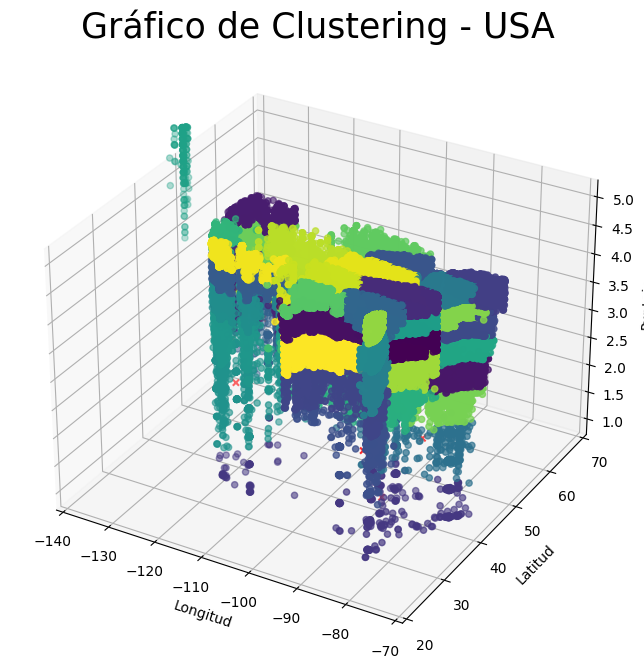

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Obtener los datos de PruebaUbi
X = data_area[['latitude', 'longitude', 'avg_rating']]

# Escalar las variables de entrada
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar el algoritmo de clustering K-means
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(X_scaled)

# Obtener los centroides de cada cluster
centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Obtener las etiquetas de cluster asignadas a cada punto
labels = kmeans.labels_

# Crear una figura 3D
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')


# Graficar los puntos con colores de acuerdo a los clusters
ax.scatter3D(X['longitude'], X['latitude'], X['avg_rating'], c=labels)

# Graficar los centroides con un marcador diferente
ax.scatter3D(centers[:, 1], centers[:, 0], centers[:, 2], c='red', marker='x')

# Configurar etiquetas de los ejes con los valores originales
plt.title('Gráfico de Clustering - USA', fontsize=25)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_zlabel('Puntaje')
ax.zaxis.set_label_coords(0.01, 1.1)

# Establecer el límite del eje x (longitud)
ax.set_xlim(-140, -70)
ax.set_ylim(20, 70)


# Mostrar la figura
plt.show()